以前都是学着别人的baseline用，这次终于轮到我可以为大家贡献一下了哈哈哈

In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
from d2l import torch as d2l


In [2]:
# 看看label文件长啥样
dataset_path = '/home/data/datasets/competitions/classify-leaves'
labels_dataframe = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
labels_dataframe.head(5)


,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
labels_dataframe.describe()


,image,label
count,18353,18353
unique,18353,176
top,images/14523.jpg,maclura_pomifera
freq,1,353


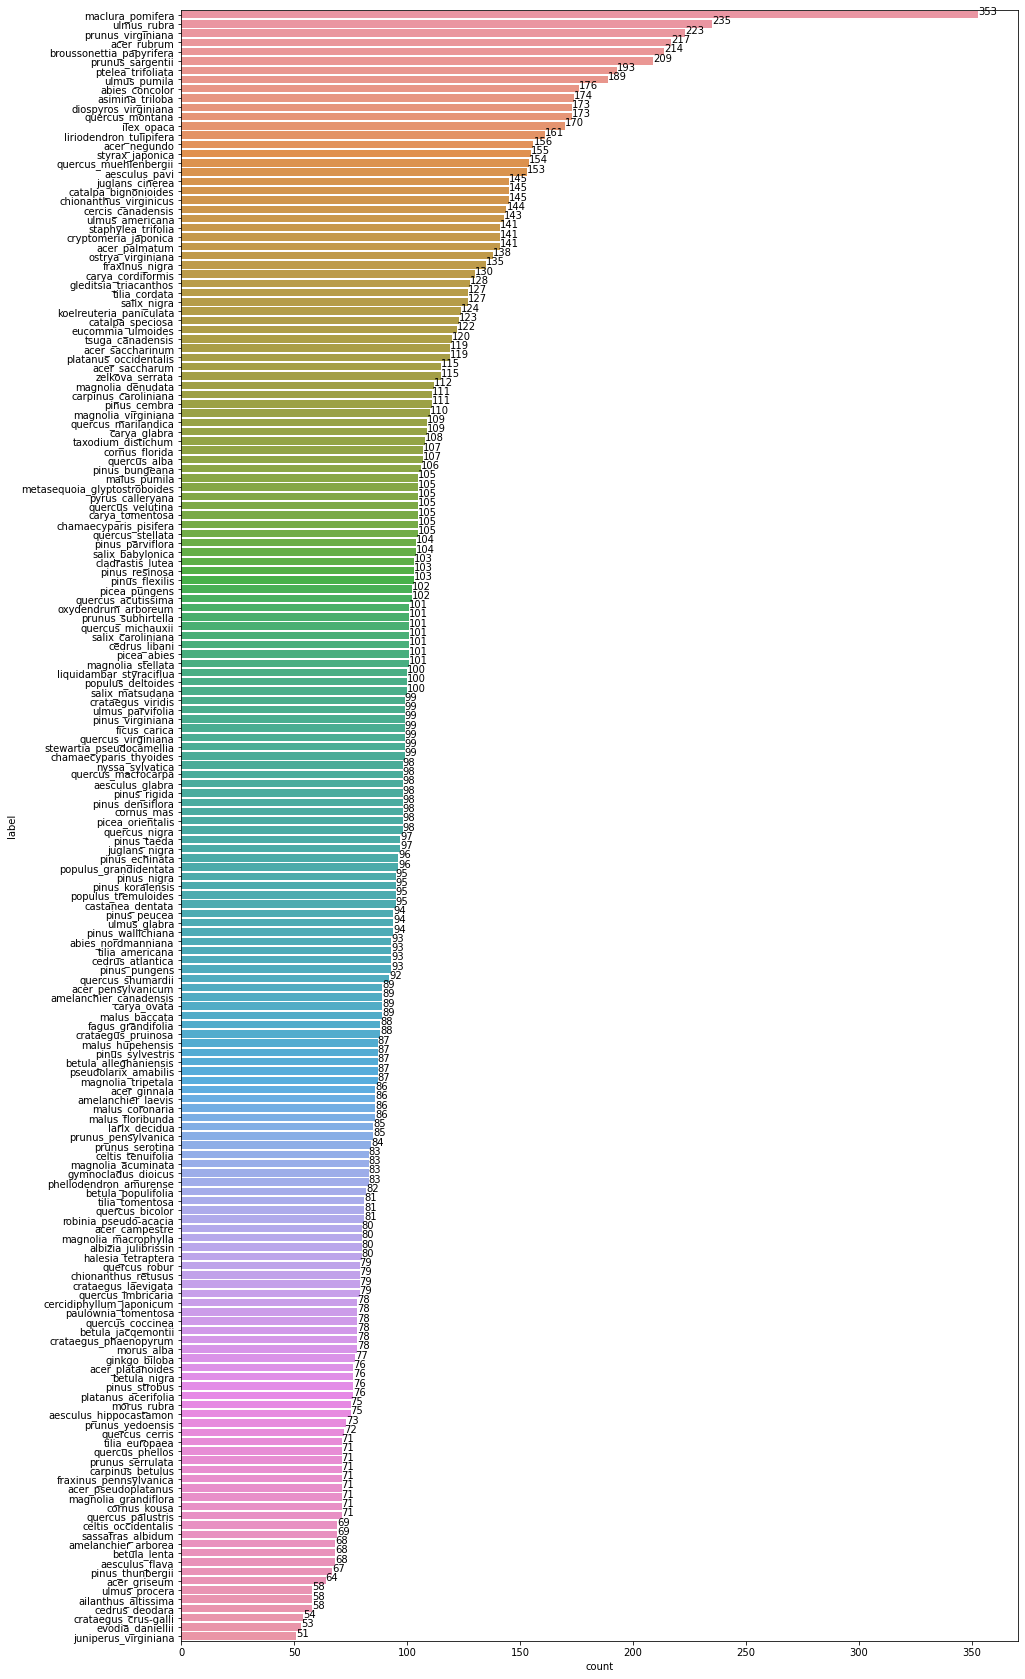

In [4]:
# function to show bar length

def barw(ax):
    # 在sns绘制的图上进行标记的函数
    # 首先是获取形状，然后根据图形的大小实际去定位位置
    for p in ax.patches:
        val = p.get_width()  # height of the bar
        x = p.get_x() + p.get_width()  # x- position
        y = p.get_y() + p.get_height()/2  # y-position
        ax.annotate(round(val, 2), (x, y))

# finding top leaves


plt.figure(figsize=(15, 30))
# sns根据数量统计绘图
ax0 = sns.countplot(
    y=labels_dataframe['label'], order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()


In [5]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]


176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [6]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num


{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [7]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v: k for k, v in class_to_num.items()}
num_to_class


{0: 'abies_concolor',
 1: 'abies_nordmanniana',
 2: 'acer_campestre',
 3: 'acer_ginnala',
 4: 'acer_griseum',
 5: 'acer_negundo',
 6: 'acer_palmatum',
 7: 'acer_pensylvanicum',
 8: 'acer_platanoides',
 9: 'acer_pseudoplatanus',
 10: 'acer_rubrum',
 11: 'acer_saccharinum',
 12: 'acer_saccharum',
 13: 'aesculus_flava',
 14: 'aesculus_glabra',
 15: 'aesculus_hippocastamon',
 16: 'aesculus_pavi',
 17: 'ailanthus_altissima',
 18: 'albizia_julibrissin',
 19: 'amelanchier_arborea',
 20: 'amelanchier_canadensis',
 21: 'amelanchier_laevis',
 22: 'asimina_triloba',
 23: 'betula_alleghaniensis',
 24: 'betula_jacqemontii',
 25: 'betula_lenta',
 26: 'betula_nigra',
 27: 'betula_populifolia',
 28: 'broussonettia_papyrifera',
 29: 'carpinus_betulus',
 30: 'carpinus_caroliniana',
 31: 'carya_cordiformis',
 32: 'carya_glabra',
 33: 'carya_ovata',
 34: 'carya_tomentosa',
 35: 'castanea_dentata',
 36: 'catalpa_bignonioides',
 37: 'catalpa_speciosa',
 38: 'cedrus_atlantica',
 39: 'cedrus_deodara',
 40: 'c

In [8]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256, transforms=None):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """

        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(
            csv_path, header=None)  # header=None是去掉表头部分
        # 计算 length, 分割训练集和验证集
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        self.transforms = transforms

        if mode == 'train':
            # 第一列包含图像文件的名称
            # self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            self.train_image = np.asarray(
                self.data_info.iloc[1:self.train_len, 0])
            # 第二列是图像的 label
            self.train_label = np.asarray(
                self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(
                self.data_info.iloc[self.train_len:, 0])
            self.valid_label = np.asarray(
                self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image

        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(os.path.join(
            self.file_path, single_image_name))

        # 如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        # 设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        # 刚才查看了所有图片，应该都是裁剪好的224*224，应该可以删除第一步的Resize操作
        #
        # if self.mode == 'train':
        #     transform = transforms.Compose([
        #         # transforms.Resize((224, 224)),
        #         transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转 选择一个概率
        #         transforms.ToTensor()
        #     ])
        # else:
        #     # valid和test不做数据增强
        #     transform = transforms.Compose([
        #         # transforms.Resize((224, 224)),
        #         transforms.ToTensor()
        #     ])

        img_as_img = self.transforms(img_as_img)

        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  # 返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len


In [14]:
dataset_path = '/home/data/datasets/competitions/classify-leaves'
train_path = os.path.join(dataset_path, 'train.csv')
test_path = os.path.join(dataset_path, 'test.csv')
# csv文件中已经images的路径了，因此这里只到上一级目录
img_folder_path = dataset_path
model_output_path = './kaggle_leaves_competition_model'
d2l.make_dir((model_output_path))

# 如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

# 设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
# 刚才查看了所有图片，应该都是裁剪好的224*224，应该可以删除第一步的Resize操作
#
train_img_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转 选择一个概率
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_img_transforms = transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LeavesData(train_path, img_folder_path,
                           mode='train', transforms=train_img_transforms)
val_dataset = LeavesData(train_path, img_folder_path,
                         mode='valid', transforms=test_img_transforms)
test_dataset = LeavesData(test_path, img_folder_path,
                          mode='test', transforms=test_img_transforms)
print(train_dataset)
print(val_dataset)
print(test_dataset)


Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [15]:
# 定义data loader
batch_size = 512
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=d2l.get_dataloader_workers()
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=d2l.get_dataloader_workers()
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=d2l.get_dataloader_workers()
)


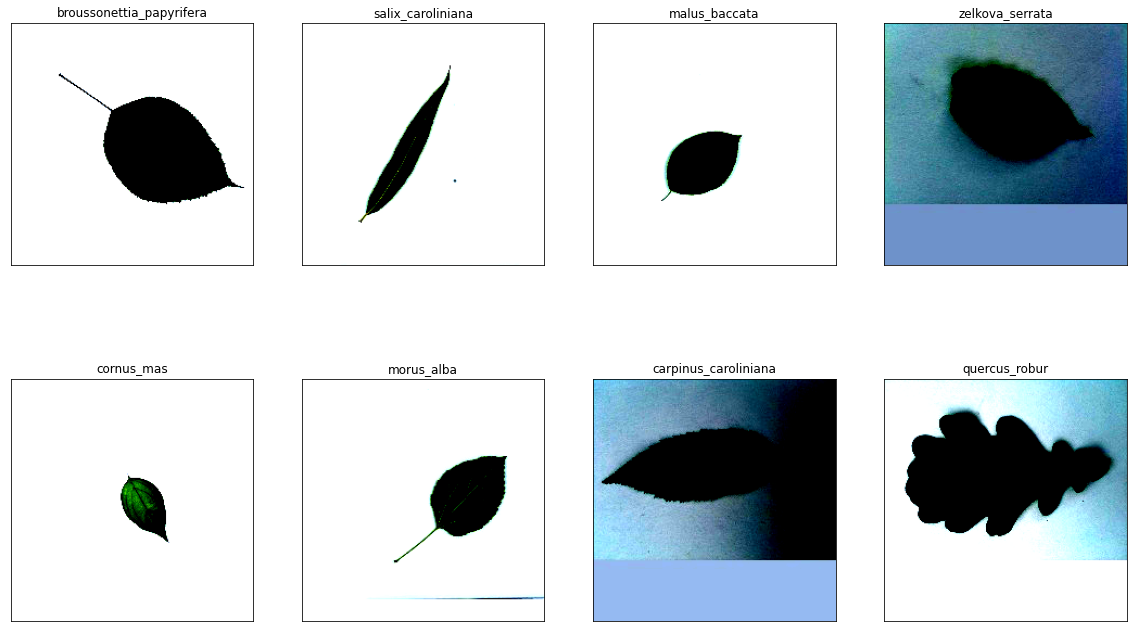

In [16]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)

    return image


fig = plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()

for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()


In [38]:
# 看一下是在cpu还是GPU上
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


device = get_device()
print(device)


cuda


In [20]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型

# 预训练的一个例子，通过保存fc层的input size，然后直接替换掉最后的fc层
def res_model(num_classes, resnet_type=34, feature_extract=False, use_pretrained=True):
    if resnet_type == 34:
        model_ft = models.resnet34(
            weights='ResNet34_Weights.DEFAULT' if use_pretrained else None)
    else:
        model_ft = models.resnet18(
            weights='ResNet18_Weights.DEFAULT' if use_pretrained else None)
    # set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft


In [18]:
# 超参数
learning_rate = 5e-6
weight_decay = 1e-3
num_epoch = 150
model_path = os.path.join(model_output_path, 'pre_res_model_2.ckpt')


In [19]:

# Initialize a model, and put it on the device specified.
devices = d2l.try_all_gpus()
model = nn.DataParallel(res_model(176), device_ids=devices).to(devices[0])
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(devices[0])
        labels = labels.to(devices[0])
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(
        f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(devices[0]))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(devices[0]))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(devices[0])).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(
        f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        if isinstance(model, torch.nn.DataParallel):
            torch.save(model.module.state_dict(), model_path)
        else:
            torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


[ Train | 001/150 ] loss = 5.35585, acc = 0.00663


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 001/150 ] loss = 5.28704, acc = 0.00439
saving model with acc 0.004


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 002/150 ] loss = 5.23723, acc = 0.01010


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 002/150 ] loss = 5.18870, acc = 0.00850
saving model with acc 0.009


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 003/150 ] loss = 5.09713, acc = 0.01703


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 003/150 ] loss = 5.08186, acc = 0.01773
saving model with acc 0.018


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 004/150 ] loss = 4.95617, acc = 0.02894


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 004/150 ] loss = 4.96562, acc = 0.03547
saving model with acc 0.035


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 005/150 ] loss = 4.79357, acc = 0.06122


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 005/150 ] loss = 4.83848, acc = 0.06796
saving model with acc 0.068


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 006/150 ] loss = 4.62628, acc = 0.10555


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 006/150 ] loss = 4.70203, acc = 0.11157
saving model with acc 0.112


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 007/150 ] loss = 4.45630, acc = 0.14891


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 007/150 ] loss = 4.56106, acc = 0.13448
saving model with acc 0.134


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 008/150 ] loss = 4.28914, acc = 0.18782


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 008/150 ] loss = 4.42032, acc = 0.17143
saving model with acc 0.171


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 009/150 ] loss = 4.13772, acc = 0.21778


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 009/150 ] loss = 4.28638, acc = 0.19434
saving model with acc 0.194


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 010/150 ] loss = 3.99519, acc = 0.24636


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


[ Valid | 010/150 ] loss = 4.16003, acc = 0.21999
saving model with acc 0.220


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 011/150 ] loss = 3.85669, acc = 0.27666


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 011/150 ] loss = 4.03732, acc = 0.23915
saving model with acc 0.239


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 012/150 ] loss = 3.73348, acc = 0.29660


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 012/150 ] loss = 3.91757, acc = 0.26054
saving model with acc 0.261


100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


[ Train | 013/150 ] loss = 3.61118, acc = 0.31783


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


[ Valid | 013/150 ] loss = 3.80879, acc = 0.27446
saving model with acc 0.274


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 014/150 ] loss = 3.49415, acc = 0.34153


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 014/150 ] loss = 3.69909, acc = 0.29370
saving model with acc 0.294


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 015/150 ] loss = 3.38449, acc = 0.36591


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 015/150 ] loss = 3.59454, acc = 0.31774
saving model with acc 0.318


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 016/150 ] loss = 3.27645, acc = 0.39021


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


[ Valid | 016/150 ] loss = 3.49566, acc = 0.33312
saving model with acc 0.333


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 017/150 ] loss = 3.17991, acc = 0.40391


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 017/150 ] loss = 3.40398, acc = 0.35158
saving model with acc 0.352


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 018/150 ] loss = 3.07866, acc = 0.42416


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 018/150 ] loss = 3.31506, acc = 0.36619
saving model with acc 0.366


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 019/150 ] loss = 2.98638, acc = 0.43919


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 019/150 ] loss = 3.22432, acc = 0.38172
saving model with acc 0.382


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 020/150 ] loss = 2.89727, acc = 0.45117


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 020/150 ] loss = 3.14071, acc = 0.39173
saving model with acc 0.392


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 021/150 ] loss = 2.81165, acc = 0.47086


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 021/150 ] loss = 3.06348, acc = 0.40516
saving model with acc 0.405


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 022/150 ] loss = 2.72646, acc = 0.48245


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 022/150 ] loss = 2.98283, acc = 0.42025
saving model with acc 0.420


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 023/150 ] loss = 2.65006, acc = 0.49914


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 023/150 ] loss = 2.91454, acc = 0.43173
saving model with acc 0.432


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 024/150 ] loss = 2.57547, acc = 0.51267


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 024/150 ] loss = 2.83689, acc = 0.43710
saving model with acc 0.437


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 025/150 ] loss = 2.49980, acc = 0.52250


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 025/150 ] loss = 2.76540, acc = 0.44784
saving model with acc 0.448


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 026/150 ] loss = 2.42980, acc = 0.53099


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 026/150 ] loss = 2.70992, acc = 0.45590
saving model with acc 0.456


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 027/150 ] loss = 2.36321, acc = 0.54673


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 027/150 ] loss = 2.63689, acc = 0.46709
saving model with acc 0.467


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 028/150 ] loss = 2.29621, acc = 0.55691


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 028/150 ] loss = 2.57739, acc = 0.47392
saving model with acc 0.474


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 029/150 ] loss = 2.23561, acc = 0.56791


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 029/150 ] loss = 2.51861, acc = 0.48775
saving model with acc 0.488


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 030/150 ] loss = 2.17535, acc = 0.58067


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 030/150 ] loss = 2.45572, acc = 0.50016
saving model with acc 0.500


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 031/150 ] loss = 2.11546, acc = 0.59091


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 031/150 ] loss = 2.40157, acc = 0.51183
saving model with acc 0.512


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 032/150 ] loss = 2.06119, acc = 0.59642


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 032/150 ] loss = 2.34440, acc = 0.52777
saving model with acc 0.528


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 033/150 ] loss = 2.00871, acc = 0.60801


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 033/150 ] loss = 2.28621, acc = 0.53802
saving model with acc 0.538


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 034/150 ] loss = 1.95255, acc = 0.62160


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 034/150 ] loss = 2.23744, acc = 0.54676
saving model with acc 0.547


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 035/150 ] loss = 1.90356, acc = 0.63187


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 035/150 ] loss = 2.18424, acc = 0.55482
saving model with acc 0.555


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 036/150 ] loss = 1.85347, acc = 0.64143


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 036/150 ] loss = 2.13673, acc = 0.56283
saving model with acc 0.563


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 037/150 ] loss = 1.80435, acc = 0.64884


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 037/150 ] loss = 2.08524, acc = 0.57333
saving model with acc 0.573


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 038/150 ] loss = 1.75820, acc = 0.66238


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 038/150 ] loss = 2.04498, acc = 0.57793
saving model with acc 0.578


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 039/150 ] loss = 1.71399, acc = 0.67112


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 039/150 ] loss = 1.99332, acc = 0.58760
saving model with acc 0.588


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 040/150 ] loss = 1.66999, acc = 0.67806


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


[ Valid | 040/150 ] loss = 1.94953, acc = 0.59497
saving model with acc 0.595


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 041/150 ] loss = 1.62454, acc = 0.68970


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 041/150 ] loss = 1.91012, acc = 0.59961
saving model with acc 0.600


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 042/150 ] loss = 1.58266, acc = 0.69748


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 042/150 ] loss = 1.86434, acc = 0.61255
saving model with acc 0.613


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 043/150 ] loss = 1.54528, acc = 0.70478


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 043/150 ] loss = 1.82577, acc = 0.61426
saving model with acc 0.614


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 044/150 ] loss = 1.50583, acc = 0.71040


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 044/150 ] loss = 1.79070, acc = 0.62589
saving model with acc 0.626


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 045/150 ] loss = 1.46870, acc = 0.72117


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 045/150 ] loss = 1.74692, acc = 0.63659
saving model with acc 0.637


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 046/150 ] loss = 1.42804, acc = 0.73098


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


[ Valid | 046/150 ] loss = 1.71198, acc = 0.64225
saving model with acc 0.642


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 047/150 ] loss = 1.39418, acc = 0.73326


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 047/150 ] loss = 1.67789, acc = 0.64757
saving model with acc 0.648


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 048/150 ] loss = 1.36113, acc = 0.74353


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 048/150 ] loss = 1.63634, acc = 0.65949
saving model with acc 0.659


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 049/150 ] loss = 1.32381, acc = 0.74986


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


[ Valid | 049/150 ] loss = 1.60310, acc = 0.66413
saving model with acc 0.664


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 050/150 ] loss = 1.29100, acc = 0.75881


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 050/150 ] loss = 1.56530, acc = 0.67536
saving model with acc 0.675


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 051/150 ] loss = 1.26181, acc = 0.76036


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 051/150 ] loss = 1.53637, acc = 0.67951
saving model with acc 0.680


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 052/150 ] loss = 1.22934, acc = 0.76776


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 052/150 ] loss = 1.49611, acc = 0.68679
saving model with acc 0.687


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 053/150 ] loss = 1.19820, acc = 0.77597


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 053/150 ] loss = 1.47061, acc = 0.69143
saving model with acc 0.691


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 054/150 ] loss = 1.17251, acc = 0.77699


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 054/150 ] loss = 1.44013, acc = 0.70497
saving model with acc 0.705


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 055/150 ] loss = 1.14075, acc = 0.78405


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 055/150 ] loss = 1.41332, acc = 0.70814
saving model with acc 0.708


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 056/150 ] loss = 1.11342, acc = 0.79274


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


[ Valid | 056/150 ] loss = 1.38595, acc = 0.71424
saving model with acc 0.714


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 057/150 ] loss = 1.08884, acc = 0.79486


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 057/150 ] loss = 1.35450, acc = 0.71815
saving model with acc 0.718


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 058/150 ] loss = 1.06543, acc = 0.79900


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 058/150 ] loss = 1.32954, acc = 0.72856
saving model with acc 0.729


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


[ Train | 059/150 ] loss = 1.03647, acc = 0.80533


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 059/150 ] loss = 1.30143, acc = 0.73868
saving model with acc 0.739


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 060/150 ] loss = 1.01007, acc = 0.81291


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 060/150 ] loss = 1.27768, acc = 0.73730


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 061/150 ] loss = 0.98547, acc = 0.81772


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 061/150 ] loss = 1.25161, acc = 0.74170
saving model with acc 0.742


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 062/150 ] loss = 0.96395, acc = 0.82239


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 062/150 ] loss = 1.22452, acc = 0.74658
saving model with acc 0.747


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 063/150 ] loss = 0.94311, acc = 0.82078


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 063/150 ] loss = 1.19960, acc = 0.75044
saving model with acc 0.750


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 064/150 ] loss = 0.91785, acc = 0.82930


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 064/150 ] loss = 1.17241, acc = 0.75606
saving model with acc 0.756


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 065/150 ] loss = 0.89873, acc = 0.83526


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 065/150 ] loss = 1.15725, acc = 0.75752
saving model with acc 0.758


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 066/150 ] loss = 0.87846, acc = 0.83865


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


[ Valid | 066/150 ] loss = 1.13145, acc = 0.76456
saving model with acc 0.765


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 067/150 ] loss = 0.85504, acc = 0.84145


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


[ Valid | 067/150 ] loss = 1.11167, acc = 0.76944
saving model with acc 0.769


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 068/150 ] loss = 0.83692, acc = 0.84566


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 068/150 ] loss = 1.08438, acc = 0.77408
saving model with acc 0.774


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 069/150 ] loss = 0.81301, acc = 0.85125


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 069/150 ] loss = 1.06963, acc = 0.77486
saving model with acc 0.775


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 070/150 ] loss = 0.79974, acc = 0.85097


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 070/150 ] loss = 1.04622, acc = 0.78018
saving model with acc 0.780


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 071/150 ] loss = 0.77723, acc = 0.85673


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 071/150 ] loss = 1.03554, acc = 0.78023
saving model with acc 0.780


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 072/150 ] loss = 0.76273, acc = 0.86232


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 072/150 ] loss = 1.00298, acc = 0.78556
saving model with acc 0.786


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


[ Train | 073/150 ] loss = 0.74347, acc = 0.86414


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 073/150 ] loss = 0.99333, acc = 0.78991
saving model with acc 0.790


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 074/150 ] loss = 0.72924, acc = 0.86660


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 074/150 ] loss = 0.96434, acc = 0.79459
saving model with acc 0.795


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 075/150 ] loss = 0.71193, acc = 0.87024


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


[ Valid | 075/150 ] loss = 0.94916, acc = 0.79821
saving model with acc 0.798


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 076/150 ] loss = 0.69793, acc = 0.87147


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 076/150 ] loss = 0.92892, acc = 0.79845
saving model with acc 0.798


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 077/150 ] loss = 0.68756, acc = 0.87357


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 077/150 ] loss = 0.91094, acc = 0.80593
saving model with acc 0.806


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 078/150 ] loss = 0.67098, acc = 0.87568


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 078/150 ] loss = 0.90674, acc = 0.80691
saving model with acc 0.807


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 079/150 ] loss = 0.65416, acc = 0.88153


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 079/150 ] loss = 0.88468, acc = 0.81106
saving model with acc 0.811


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 080/150 ] loss = 0.63853, acc = 0.88258


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 080/150 ] loss = 0.86456, acc = 0.81521
saving model with acc 0.815


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 081/150 ] loss = 0.62840, acc = 0.88161


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 081/150 ] loss = 0.85525, acc = 0.81550
saving model with acc 0.815


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 082/150 ] loss = 0.61428, acc = 0.88615


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 082/150 ] loss = 0.83756, acc = 0.81789
saving model with acc 0.818


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 083/150 ] loss = 0.59896, acc = 0.88929


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 083/150 ] loss = 0.83175, acc = 0.82107
saving model with acc 0.821


100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


[ Train | 084/150 ] loss = 0.58867, acc = 0.89191


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 084/150 ] loss = 0.81337, acc = 0.82366
saving model with acc 0.824


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 085/150 ] loss = 0.57424, acc = 0.89386


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 085/150 ] loss = 0.80162, acc = 0.82615
saving model with acc 0.826


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 086/150 ] loss = 0.55927, acc = 0.89905


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 086/150 ] loss = 0.78576, acc = 0.83050
saving model with acc 0.830


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 087/150 ] loss = 0.55415, acc = 0.89575


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 087/150 ] loss = 0.77084, acc = 0.83651
saving model with acc 0.837


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 088/150 ] loss = 0.54439, acc = 0.89918


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 088/150 ] loss = 0.76187, acc = 0.83172


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 089/150 ] loss = 0.52838, acc = 0.90343


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 089/150 ] loss = 0.74669, acc = 0.83396


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 090/150 ] loss = 0.52041, acc = 0.90352


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 090/150 ] loss = 0.74179, acc = 0.83640


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 091/150 ] loss = 0.50738, acc = 0.90671


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 091/150 ] loss = 0.73170, acc = 0.83616


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 092/150 ] loss = 0.50518, acc = 0.90629


100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


[ Valid | 092/150 ] loss = 0.71600, acc = 0.83734
saving model with acc 0.837


100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


[ Train | 093/150 ] loss = 0.48785, acc = 0.91079


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 093/150 ] loss = 0.69962, acc = 0.84271
saving model with acc 0.843


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 094/150 ] loss = 0.48165, acc = 0.90941


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 094/150 ] loss = 0.70371, acc = 0.84251


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 095/150 ] loss = 0.46929, acc = 0.91369


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


[ Valid | 095/150 ] loss = 0.68394, acc = 0.84779
saving model with acc 0.848


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 096/150 ] loss = 0.45947, acc = 0.91547


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 096/150 ] loss = 0.66880, acc = 0.85307
saving model with acc 0.853


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 097/150 ] loss = 0.44925, acc = 0.91736


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 097/150 ] loss = 0.65751, acc = 0.84979


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 098/150 ] loss = 0.44354, acc = 0.91847


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 098/150 ] loss = 0.65678, acc = 0.85507
saving model with acc 0.855


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 099/150 ] loss = 0.43513, acc = 0.91874


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 099/150 ] loss = 0.64355, acc = 0.85463


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 100/150 ] loss = 0.42996, acc = 0.91978


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


[ Valid | 100/150 ] loss = 0.64192, acc = 0.85438


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 101/150 ] loss = 0.41934, acc = 0.92153


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


[ Valid | 101/150 ] loss = 0.62809, acc = 0.86084
saving model with acc 0.861


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 102/150 ] loss = 0.41077, acc = 0.92338


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 102/150 ] loss = 0.62623, acc = 0.85918


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 103/150 ] loss = 0.40432, acc = 0.92287


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 103/150 ] loss = 0.61255, acc = 0.86137
saving model with acc 0.861


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 104/150 ] loss = 0.39173, acc = 0.92904


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


[ Valid | 104/150 ] loss = 0.60744, acc = 0.86068


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 105/150 ] loss = 0.38645, acc = 0.92903


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 105/150 ] loss = 0.60081, acc = 0.86044


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 106/150 ] loss = 0.38436, acc = 0.92749


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 106/150 ] loss = 0.58682, acc = 0.86191
saving model with acc 0.862


100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


[ Train | 107/150 ] loss = 0.37226, acc = 0.93136


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 107/150 ] loss = 0.57732, acc = 0.86699
saving model with acc 0.867


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 108/150 ] loss = 0.36803, acc = 0.93099


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 108/150 ] loss = 0.57092, acc = 0.86992
saving model with acc 0.870


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 109/150 ] loss = 0.36031, acc = 0.93341


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 109/150 ] loss = 0.56688, acc = 0.86894


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 110/150 ] loss = 0.35472, acc = 0.93469


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 110/150 ] loss = 0.55334, acc = 0.87236
saving model with acc 0.872


100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


[ Train | 111/150 ] loss = 0.34723, acc = 0.93624


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


[ Valid | 111/150 ] loss = 0.54950, acc = 0.87236


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 112/150 ] loss = 0.33950, acc = 0.93668


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 112/150 ] loss = 0.54129, acc = 0.87456
saving model with acc 0.875


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 113/150 ] loss = 0.33512, acc = 0.93698


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 113/150 ] loss = 0.53601, acc = 0.87593
saving model with acc 0.876


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 114/150 ] loss = 0.32893, acc = 0.93974


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


[ Valid | 114/150 ] loss = 0.53647, acc = 0.87382


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 115/150 ] loss = 0.32298, acc = 0.94035


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 115/150 ] loss = 0.52686, acc = 0.87578


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 116/150 ] loss = 0.31786, acc = 0.94199


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 116/150 ] loss = 0.51901, acc = 0.87578


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 117/150 ] loss = 0.30994, acc = 0.94328


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 117/150 ] loss = 0.51382, acc = 0.87817
saving model with acc 0.878


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 118/150 ] loss = 0.30865, acc = 0.94294


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 118/150 ] loss = 0.51083, acc = 0.87602


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


[ Train | 119/150 ] loss = 0.29993, acc = 0.94526


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


[ Valid | 119/150 ] loss = 0.50381, acc = 0.87822
saving model with acc 0.878


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 120/150 ] loss = 0.29973, acc = 0.94573


100%|██████████| 8/8 [00:02<00:00,  2.72it/s]


[ Valid | 120/150 ] loss = 0.49209, acc = 0.88130
saving model with acc 0.881


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 121/150 ] loss = 0.29235, acc = 0.94795


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 121/150 ] loss = 0.49280, acc = 0.87993


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 122/150 ] loss = 0.28774, acc = 0.94668


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 122/150 ] loss = 0.48393, acc = 0.88090


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 123/150 ] loss = 0.28266, acc = 0.94795


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


[ Valid | 123/150 ] loss = 0.47297, acc = 0.88858
saving model with acc 0.889


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 124/150 ] loss = 0.27586, acc = 0.95081


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 124/150 ] loss = 0.47024, acc = 0.88437


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 125/150 ] loss = 0.27065, acc = 0.95216


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 125/150 ] loss = 0.46696, acc = 0.89009
saving model with acc 0.890


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 126/150 ] loss = 0.26525, acc = 0.95169


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 126/150 ] loss = 0.46176, acc = 0.88956


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 127/150 ] loss = 0.26281, acc = 0.95233


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


[ Valid | 127/150 ] loss = 0.45182, acc = 0.88980


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 128/150 ] loss = 0.25891, acc = 0.95374


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 128/150 ] loss = 0.44997, acc = 0.88814


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 129/150 ] loss = 0.25474, acc = 0.95529


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 129/150 ] loss = 0.44181, acc = 0.89005


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 130/150 ] loss = 0.25115, acc = 0.95341


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 130/150 ] loss = 0.44120, acc = 0.88936


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 131/150 ] loss = 0.24610, acc = 0.95408


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 131/150 ] loss = 0.43348, acc = 0.88985


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 132/150 ] loss = 0.24168, acc = 0.95543


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 132/150 ] loss = 0.43240, acc = 0.89205
saving model with acc 0.892


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 133/150 ] loss = 0.24221, acc = 0.95678


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 133/150 ] loss = 0.42702, acc = 0.89253
saving model with acc 0.893


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 134/150 ] loss = 0.23453, acc = 0.95876


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


[ Valid | 134/150 ] loss = 0.42370, acc = 0.89185


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 135/150 ] loss = 0.22895, acc = 0.95745


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 135/150 ] loss = 0.42368, acc = 0.89546
saving model with acc 0.895


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 136/150 ] loss = 0.22965, acc = 0.95778


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 136/150 ] loss = 0.41312, acc = 0.89762
saving model with acc 0.898


100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


[ Train | 137/150 ] loss = 0.22348, acc = 0.96041


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


[ Valid | 137/150 ] loss = 0.41459, acc = 0.89668


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 138/150 ] loss = 0.21978, acc = 0.95977


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 138/150 ] loss = 0.41160, acc = 0.89668


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


[ Train | 139/150 ] loss = 0.21447, acc = 0.96017


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 139/150 ] loss = 0.40821, acc = 0.89526


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 140/150 ] loss = 0.21440, acc = 0.96112


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 140/150 ] loss = 0.39995, acc = 0.89937
saving model with acc 0.899


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 141/150 ] loss = 0.21118, acc = 0.96078


100%|██████████| 8/8 [00:02<00:00,  2.72it/s]


[ Valid | 141/150 ] loss = 0.39752, acc = 0.89815


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 142/150 ] loss = 0.20943, acc = 0.96165


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 142/150 ] loss = 0.39303, acc = 0.90250
saving model with acc 0.902


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


[ Train | 143/150 ] loss = 0.20625, acc = 0.96095


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 143/150 ] loss = 0.39078, acc = 0.90181


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 144/150 ] loss = 0.20018, acc = 0.96303


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 144/150 ] loss = 0.38425, acc = 0.90616
saving model with acc 0.906


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 145/150 ] loss = 0.19836, acc = 0.96438


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


[ Valid | 145/150 ] loss = 0.38045, acc = 0.90807
saving model with acc 0.908


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 146/150 ] loss = 0.19673, acc = 0.96469


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


[ Valid | 146/150 ] loss = 0.37690, acc = 0.90572


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


[ Train | 147/150 ] loss = 0.19042, acc = 0.96552


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 147/150 ] loss = 0.37446, acc = 0.90807


100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


[ Train | 148/150 ] loss = 0.19097, acc = 0.96472


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


[ Valid | 148/150 ] loss = 0.37084, acc = 0.90909
saving model with acc 0.909


100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


[ Train | 149/150 ] loss = 0.18554, acc = 0.96606


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


[ Valid | 149/150 ] loss = 0.36582, acc = 0.91031
saving model with acc 0.910


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


[ Train | 150/150 ] loss = 0.18045, acc = 0.96774


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


[ Valid | 150/150 ] loss = 0.35921, acc = 0.91178
saving model with acc 0.912


In [21]:
saveFileName = os.path.join(model_output_path, './submission.csv')


In [22]:
# predict
model = res_model(176)

# 清除DataParallel中的多余前缀


def cleanup_state_dict(state_dict):
    new_state = {}
    for k, v in state_dict.items():
        if "module" in k:
            new_name = k[7:]
        else:
            new_name = k
        new_state[new_name] = v
    return new_state


# create model and load weights from checkpoint
model = model.to(devices[0])
model.load_state_dict(cleanup_state_dict(torch.load(model_path)))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):

    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(devices[0]))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")


100%|██████████| 18/18 [00:06<00:00,  2.92it/s]

Done!!!!!!!!!!!!!!!!!!!!!!!!!!!


要是大家觉得有用的话 多多给vote哈哈哈